# 40% Task 2
###### Aiden Williams | Ethan Zammit
## Introduction
In this project we parsed through the Enron email dataset. For the purposes of this task we only used the email addresses
used in an email. Using these emails we generated a graph connected **senders to receivers**. If a sender sends multiple
emails to a receiver, this is reflected by increasing the **weight** in the edge connecting the two addresses. Once the
graph is generated we analyse it and visualise it.
***
## List Of Contents
1. [Libraries Used](#Libraries-Used)
2. [Parsing Emails](#Parsing-Emails)
3. [Constructing The Graph](#Constructing-The-Graph)
4. [Graph Analyses](#Graph-Analyses)
5. [Graph Visualization](#Graph-Visualization)

# Libraries Used
For this task we used a number of Python libraries. Below we go over why we used these libraries.

* For **Parsing** we used the os library and the Parser class from the email library
* For **Loading** and **Writing** the parsed data we used the os and json libraries
* For **Constructing**, **Analyses** and **Visualization** we used the networkx and random libraries
* For **Visualization** we used the matplotlib and collections libraries
* In general we used the tqdm library to visualize processes
***
## Importing and Global Variables
In the below code section we import and initialize some global variables.

In [1]:
import os
from email.parser import Parser
from tqdm import tqdm
import json
import networkx as nx
import matplotlib.pyplot as plt
import collections
import random

# set root directory of dataset
dataroot = os.path.join('..','maildir') # 'EnronEmails_Filtered', 
if not os.access(dataroot, os.R_OK):
    print("Check dataroot!!")

# Parsing Emails
## What We Collect
#### Email Format:

From: sample@sample.com

To: sample@sample.com

CC: sample@sample.com

BCC: sample@sample.com

Subject: Lorem ipsum

Text: dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua.

*where to, cc and bcc are a lists of email addresses and Subject and Text are strings*

For the purpose of this task we collected the addresses in an email, i.e. the From, To, CC and BCC email addresses. Using
these addresses, we created a directed graph connecting From -> To, From -> CC, From -> BCC. If 1 email was sent from From
to: To, CC and BCC, in the generated graph, To will have 3 out going edges to To, CC and BCC. Repeated address in To, CC
or BCC are ignored, i.e. only one edge is created from From.
***
## Method

Every file located in the dataroot directory is opened and parsed. From each MIME file in the data directory data is
collected in a dictionary of the following format:
> {'subject': email['subject'], 'text': email.get_payload(), 'tos': [], 'ccs': [], 'bccs': []}

This dictionary is then saved as file.json.

Below are the functions used for this process.

In [2]:
def parseData(dic, root):
    """
    Parses data from root into dic, tqdm progress bar indicates progress.
    :param dic: dictionary that will be loaded with emails
    :param root: root directory
    :return: dic filled with data from root
    """
    for user in tqdm(os.listdir(root)):
        userPath = os.path.join(root, user)
        for folder in os.listdir(userPath):
            folderPath = os.path.join(root, user, folder)
            if os.path.isfile(folderPath):
                addMail(dic, folderPath)
                continue

            for file in os.listdir(folderPath):
                addAll(dic, os.path.join(dataroot, user, folder, file))

In [3]:
def addAll(dic, emailDir):
    """
    Add all emails in emailDir(MIME file or directory) into dic.
    :param dic: dict to add emails to
    :param emailDir: (MIME file or directory) from which the emails are being read
    :return: updated dic
    """
    if not os.path.isfile(emailDir):
        for file in os.listdir(emailDir):
            addAll(dic, os.path.join(emailDir, file))
    else:
        addMail(dic, emailDir)

In [4]:
def addMail(dic, emailDir):
    """
    Add email from emailDir(a MIME file) into dic.
    :param dic: dict to add email to
    :param emailDir: file from which the email are being read
    :return: updated dic
    """
    with open(emailDir, "r", encoding='utf-8', errors='ignore') as f:
        email = Parser().parsestr(f.read())
        key = email['from']
        if key in dic:
            value = dic.get(email['from'])
            value.append(readMail(email))
            dic.update({key: value})
        else:
            value = [readMail(email)]
            dic.update({key: value})

In [5]:
def readMail(email):
    """
    Converts python email object into dict of dicts as written:
        {subject: "", text: "", tos: [], ccs: [], bccs: []}
    All duplicates that existed in tos,ccs and bccs, are removed.
    :param email: email being read
    :return: returns dict of dicts {subject: "", text: "", tos: [], cc: [], bcc: []}
    """
    update = {'subject': email['subject'], 'text': email.get_payload(), 'tos': [], 'ccs': [], 'bccs': []}
    if email['to']:
        update['tos'] = list(set(splitEmails(email, 'to')))
    if email['cc']:
        update['ccs'] = list(set(splitEmails(email, 'cc')))
        # This for if is O(n^2) it slows the parsing by a bit but it does remove duplicates in cc and bcc
        for a in update['ccs']:
            if a in update['tos']:
                update['ccs'].remove(a)
    if email['bcc']:
        update['bccs'] = list(set(splitEmails(email, 'bcc')))
        for a in update['bccs']:
            if a in update['ccs']:
                update['bccs'].remove(a)
    return update

In [6]:
def splitEmails(maillist: str, tag):
    """
    Splits email of type tag [to,cc,bcc] addresses from maillist
    :param maillist: email with lists of addresses
    :param tag: tag specified to split from
    :return: list of split emails, Duplicates are included
    """
    split = maillist[tag]
    split = split.replace("\n", "")
    split = split.replace("\t", "")
    split = split.replace(" ", "")
    return split.split(',')


In [7]:
def _saveToFile(data, path):
    """
    Saves serializable data structures to a json file.
    :param data: data to be saved.
    :param path: path where the file will be written.
    """
    print('Saving')
    with open(path, 'w') as fp:
        json.dump(data, fp, indent=4)

## Loading or Parsing

If the data has been parsed and saved before we load that into the data dictionary. Loading the data from a json is much
faster then re-parsing the dataset.

In [8]:
data = {}
path = "../intermediary/file.json"
if os.path.isfile(path) and os.access(path, os.R_OK):
    print("Docs file found!")
    print('Reading...')
    with open(path, 'r') as f:
        data = json.load(f)
    print("...done!")

else:
    print("Either file is missing or is not readable, creating file...")
    parseData(data, dataroot)
    _saveToFile(data, path=path)

Docs file found!
Reading...
...done!


# Constructing The Graph

## Graph Edges
Edges are created from, From to any address in the To, CC or BCC section of an email. We first create all the edges in the
graph and then create a NetworkX directed graph using these edges.

In [9]:
class Edge:
    """
    Simple edge class that represents and edge with weight between 2 aliases
    """
    def __init__(self, alias1: str, alias2: str, weight=0):
        self.alias1 = alias1
        self.alias2 = alias2
        self.weight = weight

## Edge Dictionary
All the edges in the graph representing the entire dataset are stored in edges in the format:

> {tuple(from, to): weight}

The Edges are added to edges via addEdgeToDict.

In [10]:
edges = {}
def addEdgeToDict(frm, to):
    """
    Adds edge from -> to to dictionary, incrementing weight if the tuple(frm, to) already exists in edges
    :param frm: from user
    :param to: to user
    :return: dictionary of edges key=tuple(frm,to):value=weight
    """
    key = tuple([frm, to])
    if key in edges:
        w = edges.get(key)
        w += 1
        edges[key] = w
    else:
        edges.update({key: 1})

print("\nBuilding Edges")
for _from in tqdm(data):
    emails = data.get(_from)
    for e in emails:
        for t in e['tos']:
            addEdgeToDict(_from, t)
        for c in e['ccs']:
            addEdgeToDict(_from, c)
        for b in e['bccs']:
            addEdgeToDict(_from, b)

  2%|▏         | 262/15236 [00:00<00:05, 2594.08it/s]


Building Edges


100%|██████████| 15236/15236 [00:01<00:00, 12717.39it/s]


## NetworkX Graph
Using the edges dictionary, and the add_edge() function we create dG a directed Graph.

In [11]:
dG = nx.DiGraph()
print("\nBuilding NetworkX Graph")
for edge in tqdm(edges.keys()):
    dG.add_edge(edge[0], edge[1], weight=edges.get(edge))
print("\nDone.")

 17%|█▋        | 55051/316767 [00:00<00:00, 544905.96it/s]


Building NetworkX Graph


100%|██████████| 316767/316767 [00:00<00:00, 514201.15it/s]


Done.


# Graph Analyses
To analyse the graph we where required to do a number of tasks:
1. [Degree Distribution](#Degree-Distribution)
2. [Diameter](#Diameter)
3. [Average Path Length](#Average-Path-Length)
4. [Global Clustering Coefficient](#Global-Clustering-Coefficient)
5. [Compactness](#Compactness)
6. [Betwenness Centrality](#Betwenness-Centrality)
7. [Page Rank](#Page-Rank)

The process of each task will be detailed in their respective md section.

## Degree Distribution
Using a number of histograms we visualize the degree distribution of the entire graph. A number of histograms are drawn
to better visualize the distribution. Each plot will have inline comments describing what the plot is visualizing.
**REDO inline comments**

P(k) for all degree types(undirected/in/out) is given by the Pk function

#### Undirected Degree Distribution

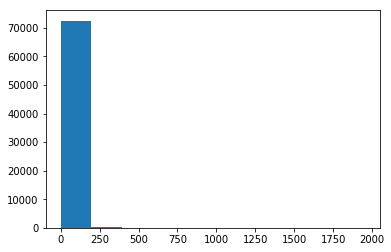

In [12]:
'''
The majority of nodes are connected less than 125 the node with the most connections reaches 1750.
'''
degrees = [dG.degree(n) for n in dG.nodes]
plt.hist(degrees)
plt.show()

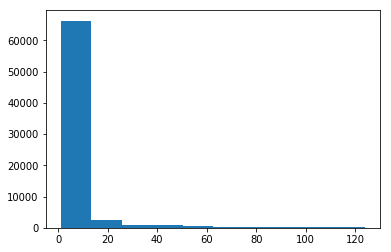

In [13]:
'''
From this histogram it is revealed that most nodes have a degree that is less than 20
'''
degrees = [dG.degree(n) for n in dG.nodes if dG.degree(n) < 125]
plt.hist(degrees)
plt.show()

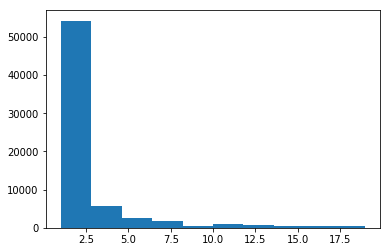

In [14]:
'''
From this histogram it is revealed that most nodes have a degree of 2
'''
degrees = [dG.degree(n) for n in dG.nodes if dG.degree(n) < 20]
plt.hist(degrees)
plt.show()

In [15]:
nodes_more_than2 = len([dG.degree(n) for n in dG.nodes if dG.degree(n) > 2])
print("Nodes that have a degree more than 2:")
print(nodes_more_than2)
print("Total number of nodes:")
print(len(dG.nodes))

Nodes that have a degree more than 2:
18808
Total number of nodes:
73025


#### In Degree Distribution

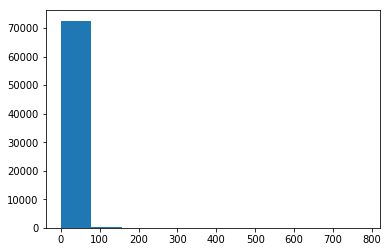

In [16]:
'''
The majority of nodes are connected less than 100 the node with the highest in degree reaches 800.
'''
degrees = [dG.in_degree(n) for n in dG.nodes]
plt.hist(degrees)
plt.show()

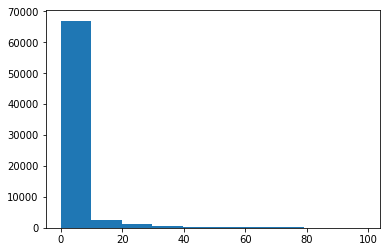

In [17]:
'''
From this histogram it is revealed that most nodes have an in-degree that is less than 10
'''
degrees = [dG.in_degree(n) for n in dG.nodes if dG.in_degree(n) <  100]
plt.hist(degrees)
plt.show()

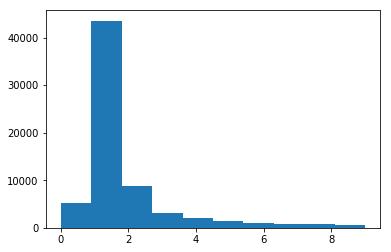

In [18]:
'''
From this histogram it is revealed that most nodes have an in-degree of 2, also a significant number have an in-degree
of 3
'''
degrees = [dG.in_degree(n) for n in dG.nodes if dG.in_degree(n) < 10]
plt.hist(degrees)
plt.show()

In [19]:
nodes_more_than3 = len([dG.in_degree(n) for n in dG.nodes if dG.in_degree(n) > 3])
print("Nodes that have a degree more than 3:")
print(nodes_more_than3)
print("Total number of nodes:")
print(len(dG.nodes))

Nodes that have a degree more than 3:
12371
Total number of nodes:
73025


#### Out Degree Distribution

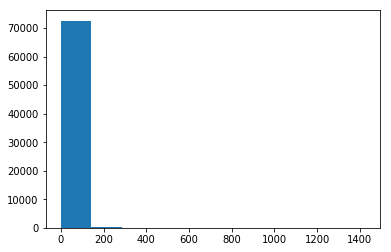

In [20]:
'''
The majority of nodes have an out-degree less than 100 the node with the highest out degree of 1400.
'''
degrees = [dG.out_degree(n) for n in dG.nodes]
plt.hist(degrees)
plt.show()

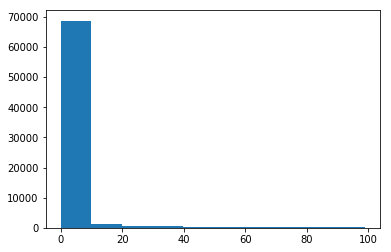

In [21]:
'''
From this histogram it is revealed that most nodes have an in-degree that is less than 10
'''
degrees = [dG.out_degree(n) for n in dG.nodes if dG.out_degree(n) <  100]
plt.hist(degrees)
plt.show()

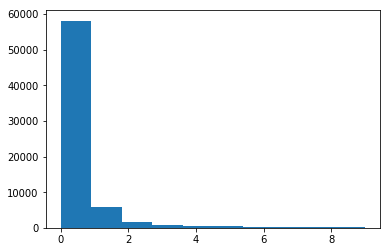

In [22]:
'''
From this histogram it is revealed that most nodes have an out-degree of 1
'''
degrees = [dG.out_degree(n) for n in dG.nodes if dG.out_degree(n) < 10]
plt.hist(degrees)
plt.show()

In [23]:
nodes_more_than1 = len([dG.out_degree(n) for n in dG.nodes if dG.out_degree(n) > 1])
print("Nodes that have an out degree more than 1:")
print(nodes_more_than1)
print("Total number of nodes:")
print(len(dG.nodes))

Nodes that have an out degree more than 1:
8964
Total number of nodes:
73025


In [24]:
#Pk
def Pk(k):
    """
    :param k: degree that is being tested
    :return: degree distribution for out, in, all degrees
    """
    Nk1 = len([dG.out_degree(n) for n in dG.nodes if dG.out_degree(n) == k])
    Nk2 = len([dG.in_degree(n) for n in dG.nodes if dG.in_degree(n) == k])
    Nk3 = len([dG.degree(n) for n in dG.nodes if dG.degree(n) == k])

    return Nk1/len(dG.nodes), Nk2/len(dG.nodes), Nk3/len(dG.nodes)

## Sub Graphs
Moving forward graph analyses was proving difficult to do on the entire graph. Hence we created a number of sub graphs
that we thought make sense analysing.

Large degree users is a connected graph of 3 nodes with highest degree (wonky still but anyways)

In [25]:
large_degree_users = [n for n in dG.nodes if dG.degree(n) > 1700]

new_edges = {k: edges.get(k) for k in edges if k[0] in large_degree_users or k[1] in large_degree_users}
DG = nx.DiGraph()
for edge in new_edges.keys():
    DG.add_edge(edge[0], edge[1], weight=new_edges.get(edge))
print(len(DG))

4269


# Diameter
The diameter of a graph is the longest shortest path. To show this one would have to get the all shortest paths in the
graph and select the longest one.

In [26]:
print(nx.diameter(DG.to_undirected()))

4


# Average Path Length
The average path length is given by the equation:

In [27]:
print(nx.average_shortest_path_length(DG.to_undirected()))

2.749035954373886


# Global Clustering Coefficient
The global clustering coefficient is calculated by counting all the clustering coefficients of each node and then dividing
the total by the total number of nodes.

In [28]:
global_clustering_coefficient = 0
for node in DG.nodes():
    neighbours=[n for n in nx.neighbors(DG,node)]
    n_neighbors=len(neighbours)
    n_links=0
    if n_neighbors>1:
        for node1 in neighbours:
            for node2 in neighbours:
                if DG.has_edge(node1,node2):
                    n_links+=1
        n_links/=2 #because n_links is calculated twice
        clustering_coefficient=n_links/(0.5*n_neighbors*(n_neighbors-1))
        global_clustering_coefficient += clustering_coefficient
print(global_clustering_coefficient/len(DG))

0.054580391762195


# Compactness
Compactness is the ratio between the number of existing edges, and the number of all the possible edges

In [29]:
E2 = 2 * len(DG.edges)
N = len(DG) * len(DG) - len(DG)
print(E2/N)

0.0006242559038670058


# Betwenness Centrality

In [30]:
print(nx.betweenness_centrality(DG))

{'outlook-migration-team@enron.com': 0.0, 'sally.beck@enron.com': 0.17323820573528803, 'louise.kitchen@enron.com': 0.0005852867999490727, 'kenneth.lay@enron.com': 0.18451210492826353, 'arsystem@mailman.enron.com': 0.0, 'jeff.dasovich@enron.com': 0.19194346527373427, 'david.port@enron.com': 0.0, 'c..gossett@enron.com': 0.0, 'no.address@enron.com': 0.0, 'enron_update@concureworkplace.com': 0.0, 'greg.whalley@enron.com': 0.0005852867999490727, 'david.oxley@enron.com': 0.0020494416698919465, 'aod@newsdata.com': 0.0, 'rebecca.cantrell@enron.com': 0.0, 'paul.kaufman@enron.com': 0.0, 'phillip.allen@enron.com': 0.0005852867999490727, 'stephanie.miller@enron.com': 0.0, 'sarah.novosel@enron.com': 0.0, 'frank.hayden@enron.com': 0.0, 'christi.nicolay@enron.com': 0.0, 'richard.shapiro@enron.com': 0.0009213712361196224, 'tim.belden@enron.com': 0.0026347284698410205, 'perfmgmt@enron.com': 0.0, 'k..allen@enron.com': 0.0020494416698919465, 'george.wasaff@enron.com': 0.0, 'fernley.dyson@enron.com': 0.0,

# Page Rank

In [31]:
pr = nx.pagerank(DG)
print(pr)

{'outlook-migration-team@enron.com': 0.00011146063894641508, 'sally.beck@enron.com': 0.09233123899807977, 'louise.kitchen@enron.com': 0.001173757816911992, 'kenneth.lay@enron.com': 0.07752984855492369, 'arsystem@mailman.enron.com': 0.00011146063894641508, 'jeff.dasovich@enron.com': 0.11353620295339573, 'david.port@enron.com': 0.00018825873572970558, 'c..gossett@enron.com': 0.0003792499203129693, 'no.address@enron.com': 0.00011146063894641508, 'enron_update@concureworkplace.com': 0.00011146063894641508, 'greg.whalley@enron.com': 0.0004913195151190235, 'david.oxley@enron.com': 0.0002640527751380336, 'aod@newsdata.com': 0.00011491282914539618, 'rebecca.cantrell@enron.com': 0.00013792743047193683, 'paul.kaufman@enron.com': 0.0022667780531769478, 'phillip.allen@enron.com': 0.00014483181086989905, 'stephanie.miller@enron.com': 0.00018855955339032627, 'sarah.novosel@enron.com': 0.0011643786496356502, 'frank.hayden@enron.com': 0.00011146063894641508, 'christi.nicolay@enron.com': 0.000134475240

# Graph Visualization

matplotlib go brrr

In [32]:
def draw_weights_as_nodes(graph, X=45, Y=10):
    random_X_nodes = random.sample(list(graph.nodes), X)
    top = list(sorted(nx.pagerank(graph).items(), key=lambda x: x[1], reverse=True))[:Y]
    all_nodes = random_X_nodes + top
    temp_edges = {k: edges.get(k) for k in edges if k[0] in all_nodes or k[1] in all_nodes}
    TG = nx.Graph()
    for edge in temp_edges.keys():
        TG.add_edge(edge[0], edge[1], weight=temp_edges.get(edge))


    #pos_fr = nx.fruchterman_reingold_layout(TG, k=8)
    pos_fr = nx.random_layout(TG)
    plt.figure(figsize=(13, 13))
    nodes = set(TG)
    sizes = [100 * nx.degree(TG, n) for n in nodes]
    nx.draw_networkx_nodes(TG, pos=pos_fr, nodelist=nodes, node_size=sizes, node_color='green')

    # draw the edges
    ax = plt.gca()

    ax.set_axis_off()
    plt.show()

#draw_weights_as_nodes(dG)


In [33]:
random_X_nodes = random.sample(list(dG.nodes), 100)
# temp_edges = {k: edges.get(k) for k in edges if k[0] in random_X_nodes or k[1] in random_X_nodes}
# TG = nx.Graph()
# for edge in temp_edges.keys():
#     TG.add_edge(edge[0], edge[1], weight=temp_edges.get(edge))

TG = nx.subgraph(dG,random_X_nodes)

nodes = [{'name': str(i), 'size': nx.degree(TG, i)}
         for i in TG.nodes()]
links = [{'source': str(u[0]), 'target': str(u[1]), 'weight': 1}
         for u in TG.edges()]


# r = [nx.degree(TG, n) for n in TG.nodes]
# m = max(r)
# nodes = [{'name': str(n), 'size': 10 * nx.degree(TG, n)/m}
#          for n in TG.nodes()]
# r = temp_edges.values()
# m = max(r)
# links = [{'source': u[0], 'target': u[1], 'weight': temp_edges.get(u)/m}
#          for u in TG.edges]
with open('graph.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4,)


In [34]:
%%html
<div id="d3"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [48]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 1200, height = 1200;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("graph.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .attr("stroke-width", function(d) { return (d.weight); })
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", function (d){return d.size * 1000; })  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.club);
      })
      .call(force.drag);

//     // The name of each node is the node number.
//     node.append("title")
//         .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

In [36]:
def draw_weights_as_nodes(graph, X=45, Y=10):
    random_X_nodes = random.sample(list(graph.nodes), X)
    top = list(sorted(nx.pagerank(graph).items(), key=lambda x: x[1], reverse=True))[:Y]
    all_nodes = random_X_nodes + top
    temp_edges = {k: edges.get(k) for k in edges if k[0] in all_nodes or k[1] in all_nodes}
    TG = nx.Graph()
    for edge in temp_edges.keys():
        TG.add_edge(edge[0], edge[1], weight=temp_edges.get(edge))


    #pos_fr = nx.fruchterman_reingold_layout(TG, k=8)
    pos_fr = nx.random_layout(TG)
    plt.figure(figsize=(13, 13))
    nodes = set(TG)
    sizes = [100 * nx.degree(TG, n) for n in nodes]
    nx.draw_networkx_nodes(TG, pos=pos_fr, nodelist=nodes, node_size=sizes, node_color='green')

    # draw the edges
    ax = plt.gca()

    ax.set_axis_off()
    plt.show()

#draw_weights_as_nodes(dG)


In [37]:
random_X_nodes = random.sample(list(dG.nodes), 100)
# temp_edges = {k: edges.get(k) for k in edges if k[0] in random_X_nodes or k[1] in random_X_nodes}
# TG = nx.Graph()
# for edge in temp_edges.keys():
#     TG.add_edge(edge[0], edge[1], weight=temp_edges.get(edge))

TG = nx.subgraph(dG,random_X_nodes)

nodes = [{'name': str(i), 'size': nx.degree(TG, i)}
         for i in TG.nodes()]

# r = temp_edges.values()
# m = max(r)
links = [{'source': nodes.index(u[0]), 'target': nodes.index(u[1]), 'weight': 1}
          for u in TG.edges()]


# r = [nx.degree(TG, n) for n in TG.nodes]
# m = max(r)
# nodes = [{'name': str(n), 'size': 10 * nx.degree(TG, n)/m}
#          for n in TG.nodes()]
# r = temp_edges.values()
# m = max(r)
# links = [{'source': u[0], 'target': u[1], 'weight': temp_edges.get(u)/m}
#          for u in TG.edges]
with open('graph2.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4,)


In [44]:
%%html
<div id="d3"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [45]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 1200, height = 1200;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("graph2.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      //.start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .attr("stroke-width", function(d) { return (d.weight); })
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", function (d){return d.size * 1000; })  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.club);
      })
      .call(force.drag);

//     // The name of each node is the node number.
//     node.append("title")
//         .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>